In [1]:
import sys

sys.path.append('../../')

import random
import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from sklearn import datasets
from dal_toolbox.models.deterministic.train import train_one_epoch_fixmatch

In [2]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

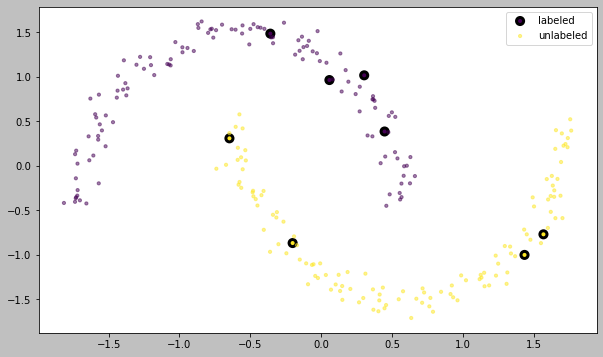

In [3]:
# Setup SSL 

class GaussianNoiseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y, mean=0, std=1, noise=0.2):
        super(GaussianNoiseDataset, self).__init__(X, y)
        self.mean = mean
        self.std = std
        self.noise = noise
        assert noise >= 0 and noise <= 1, "noise is a probability and should be between 0 and 1"

    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        X = X + torch.randn_like(X)*self.noise
        return X, y

random.seed(1)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=4) + random.sample(indices_class1, k=4)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
# Using labeled and unlabeled data for unsupervised learning
unlabeled_ds_weak = GaussianNoiseDataset(X, y, noise=0.05)
unlabeled_ds_strong = GaussianNoiseDataset(X, y, noise=0.25)

plt.figure(figsize=(10,6), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='black', linewidths=3, label='labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = 0, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [5]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

## Fixmatch

Epoch [0] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.6937 (0.6937) unsup_loss: 0.0000 (0.0000) total_loss: 0.6937 (0.6937) acc1: 50.0000 (50.0000) time: 0.0024 data: 0.0002 max mem: 1
Epoch [0] Total time: 0:00:00
Epoch [1] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.0166 (0.0166) unsup_loss: 0.0022 (0.0022) total_loss: 0.0383 (0.0383) acc1: 100.0000 (100.0000) time: 0.0020 data: 0.0002 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.1316 (0.1316) unsup_loss: 0.0097 (0.0097) total_loss: 0.2289 (0.2289) acc1: 87.5000 (87.5000) time: 0.0020 data: 0.0002 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.2545 (0.2545) unsup_loss: 0.0223 (0.0223) total_loss: 0.4779 (0.4779) acc1: 87.5000 (87.5000) time: 0.0020 data: 0.0002 max mem: 1
Epoch [3] Total time: 0:00:00
Epoch [4] [ 0/50] eta: 0:00:00 lr: 0.01 sup_loss: 0.0124 (0.0124) unsup_loss: 0.0211 (0.0211) total_loss: 0.2237 (0.2237) acc1: 100.0000 (100.0000

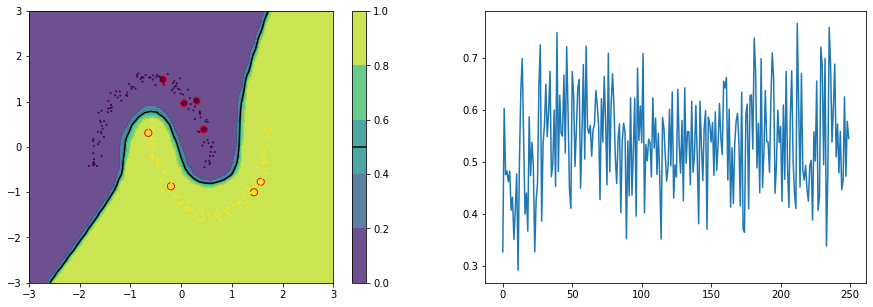

In [17]:
torch.manual_seed(0)

n_epochs = 250 # number of epochs for training
n_iter = 12500 # number of total batches over the whole training
batch_size = 8 # batch_size of labeled samples per iteration
u_ratio = 3 # Ratio of unlabeled samples to labeled samples per batch
lambda_u = 10 # Ratio of unsupervised loss partition to supervised loss of total loss
p_cutoff = 0.95 # Lower Confidence bound for useable pseudo-labels
T = 0.5 # Temperature Scaling for Sharpening

n_iter_per_epoch = n_iter // n_epochs
labeled_sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)

unlabeled_sampler1 = RandomSampler(unlabeled_ds_weak, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
unlabeled_sampler2 = RandomSampler(unlabeled_ds_strong, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
unlabeled_loader1 = DataLoader(unlabeled_ds_weak, batch_size=u_ratio*batch_size, sampler=unlabeled_sampler1)
unlabeled_loader2 = DataLoader(unlabeled_ds_strong, batch_size=u_ratio*batch_size, sampler=unlabeled_sampler2)
fix_loaders = {
        "train_sup": labeled_loader,
        "train_unsup_weak": unlabeled_loader1,
        "train_unsup_strong": unlabeled_loader2
}

fix_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
fix_model = Net(dropout_rate=0, num_classes=2)
fix_optimizer = torch.optim.SGD(fix_model.parameters(), **fix_optimizer_params)
criterion = nn.CrossEntropyLoss()

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch_fixmatch(
        model=fix_model, dataloaders=fix_loaders, criterion=criterion, 
        optimizer=fix_optimizer, device='cuda', epoch=i, lambda_u=lambda_u, T=T,
        use_cat=True, p_cutoff=p_cutoff, use_hard_labels=True)
    history.append(train_stats)

fix_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(fix_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_total_loss'] for d in history])
plt.show()

## Extreme Low-Budget Scenario

Fixmatch performs exceptionally well in a low-budget scenario, which is why we test the limits of its performance with only one label per class.

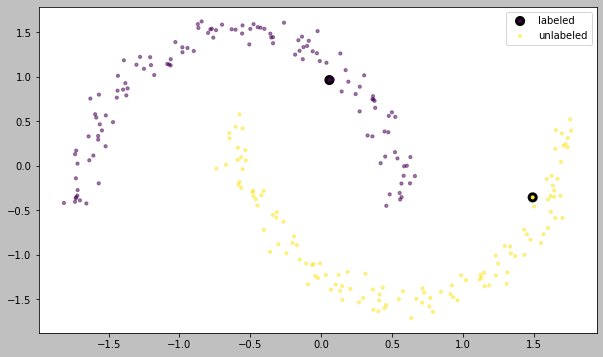

In [18]:
random.seed(1)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=1) + random.sample(indices_class1, k=1)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
# Using labeled and unlabeled data for unsupervised learning
unlabeled_ds_weak = GaussianNoiseDataset(X, y, noise=0.05)
unlabeled_ds_strong = GaussianNoiseDataset(X, y, noise=0.25)

plt.figure(figsize=(10,6), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='black', linewidths=3, label='labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

Epoch [0] [  0/100] eta: 0:00:00 lr: 0.01 sup_loss: 0.7106 (0.7106) unsup_loss: 0.0000 (0.0000) total_loss: 0.7106 (0.7106) acc1: 50.0000 (50.0000) time: 0.0026 data: 0.0002 max mem: 1
Epoch [0] Total time: 0:00:00
Epoch [1] [  0/100] eta: 0:00:00 lr: 0.01 sup_loss: 0.1457 (0.1457) unsup_loss: 0.0078 (0.0078) total_loss: 0.2628 (0.2628) acc1: 100.0000 (100.0000) time: 0.0024 data: 0.0002 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [  0/100] eta: 0:00:00 lr: 0.01 sup_loss: 0.0066 (0.0066) unsup_loss: 0.0117 (0.0117) total_loss: 0.1817 (0.1817) acc1: 100.0000 (100.0000) time: 0.0024 data: 0.0001 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [  0/100] eta: 0:00:00 lr: 0.01 sup_loss: 0.0016 (0.0016) unsup_loss: 0.0770 (0.0770) total_loss: 1.1561 (1.1561) acc1: 100.0000 (100.0000) time: 0.0024 data: 0.0001 max mem: 1
Epoch [3] Total time: 0:00:00
Epoch [4] [  0/100] eta: 0:00:00 lr: 0.01 sup_loss: 0.0001 (0.0001) unsup_loss: 0.0075 (0.0075) total_loss: 0.1123 (0.1123) acc1: 100.

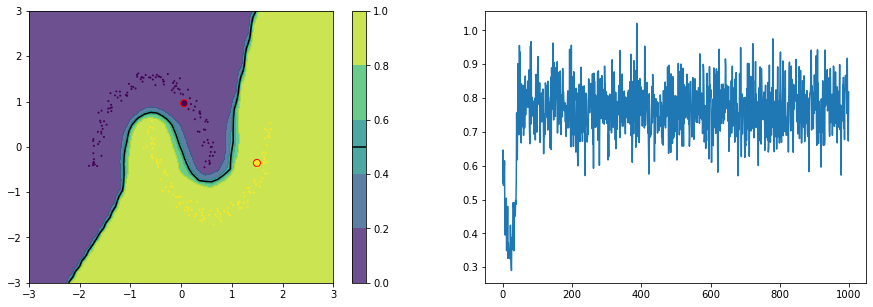

In [22]:
torch.manual_seed(0)

n_epochs = 1000 # number of epochs for training
n_iter = 100000 # number of total batches over the whole training
batch_size = 8 # batch_size of labeled samples per iteration
u_ratio = 5 # Ratio of unlabeled samples to labeled samples per batch
lambda_u = 15 # Ratio of unsupervised loss partition to supervised loss of total loss
p_cutoff = 0.95 # Lower Confidence bound for useable pseudo-labels
T = 0.5 # Temperature Scaling for Sharpening

n_iter_per_epoch = n_iter // n_epochs
labeled_sampler = RandomSampler(labeled_ds, num_samples=n_iter_per_epoch*batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)

unlabeled_sampler1 = RandomSampler(unlabeled_ds_weak, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
unlabeled_sampler2 = RandomSampler(unlabeled_ds_strong, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
unlabeled_loader1 = DataLoader(unlabeled_ds_weak, batch_size=u_ratio*batch_size, sampler=unlabeled_sampler1)
unlabeled_loader2 = DataLoader(unlabeled_ds_strong, batch_size=u_ratio*batch_size, sampler=unlabeled_sampler2)
fix_loaders = {
        "train_sup": labeled_loader,
        "train_unsup_weak": unlabeled_loader1,
        "train_unsup_strong": unlabeled_loader2
}

fix_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
fix_model = Net(dropout_rate=0, num_classes=2)
fix_optimizer = torch.optim.SGD(fix_model.parameters(), **fix_optimizer_params)
criterion = nn.CrossEntropyLoss()

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch_fixmatch(
        model=fix_model, dataloaders=fix_loaders, criterion=criterion, 
        optimizer=fix_optimizer, device='cuda', epoch=i, lambda_u=lambda_u, T=T,
        use_cat=True, p_cutoff=p_cutoff, use_hard_labels=True)
    history.append(train_stats)

fix_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(fix_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_total_loss'] for d in history])
plt.show()